Dear learning rate...

I will look for you, I will find you, and I will ???? you

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import SGD
from functools import partial
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader

# local imports
import sys
sys.path.insert(1, '../')
from modules.dsets import TrainingCovid2dSegmentationDataset, collate_fn
from modules.model import UNet3dWrapper
from modules.util.util import list_stride_splitter

In [4]:
model = UNet3dWrapper(
    in_channels=1,
    n_classes=1,
    depth=3,
    wf=4,
    padding=True,
    pad_type='replicate',
    batch_norm=True,
    up_mode='upconv')
model = model.cuda()

In [5]:
lr = 1e-7
momentum=.99
weight_decay=1e-4
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [6]:
def dice_loss_func(pred_g, label_g, epsilon=1):
    dice_correct = (pred_g * label_g).sum(dim=[-4,-3,-2,-1])
    dice_label_g = label_g.sum(dim=[-4,-3,-2,-1])
    dice_pred_g = pred_g.sum(dim=[-4,-3,-2,-1])

    dice_ratio = (2 * dice_correct + epsilon) \
        / (dice_label_g + dice_pred_g + epsilon)
    return 1 - dice_ratio

def loss_func(pred_g, label_g):
    dice_loss = dice_loss_func(pred_g, label_g)
    #fine_loss = dice_loss_func(pred_g*label_g, label_g)
    
    return dice_loss.mean()# + fine_loss.mean() * 8

criterion = loss_func

In [7]:
splitter=partial(list_stride_splitter, val_stride=10)

train_ds = TrainingCovid2dSegmentationDataset(
    is_valid=False, 
    splitter=splitter,
    width_irc=(12,192,192))

batch_size = 2

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

2020-11-21 19:25:21,630 INFO     pid:34047 modules.dsets:315:__init__ TrainingCovid2dSegmentationDataset: training mode, 179 uid's
2020-11-21 19:25:21,631 INFO     pid:34047 modules.dsets:340:__init__ TrainingCovid2dSegmentationDataset: (12, 192, 192) width_irc,  160 steps_per_epoch


The training will use one cycle learning rate so we are looking for a steep decrease and loss, and the point at which it starts to level out/diverge

In [8]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')

In [9]:
lr_finder.range_test(train_loader=train_dl, end_lr=10, num_iter=500)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.67E-03


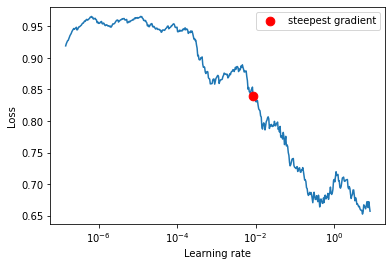

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5c2dc50d60>,
 0.008667138797389224)

In [10]:
# this was for model with depth 3, width_irc = 7,60,60
lr_finder.plot() 

In [11]:
lr_finder.reset()

In [12]:
lr_finder.range_test(train_loader=train_dl, end_lr=10, num_iter=100)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.94E+00


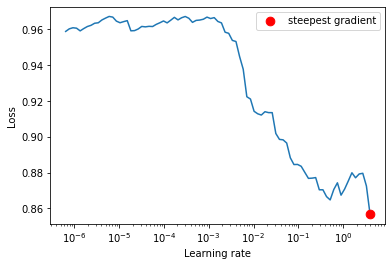

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5cb91a1ee0>, 3.9442060594376556)

In [13]:
# this was for model with depth 3, width_irc = 7,60,60
lr_finder.plot()

In [14]:
lr_finder.reset()

Based on these findings, we can set the default learning rate to a steep loss, such as 3e-3, and the max lr can be 3e-1